
# SARSA($\lambda$) on Mountain Car With a Fourier Basis

The mountain car problem starts with a car which is stuck in a sinusoidal valley and must attain the peak of the mountain on the right. If the car tries to go straight up the slope, it will fail and roll backward because the car doesn't have enough power. The only successful strategy is to go up the far slope to build up energy and then use that additional energy to make it up the desired slope.

In this report, we reproduce the results of Konidaris et al. in which the mountain car problem was solved using the SARSA($\lambda$) technique and a Fourier basis. SARSA($\lambda$) learns to approximate $Q(s,a)$, which represents the value of taking action $a$ in state $s$. Once this function has been learned, the optimal action for any state may be selected by taking $\mathrm{argmax}_a {Q(s,a)}$.

The basis used in linear function approximation defines a set of base functions that can be weighted and summed to produce some more interesting, non-linear function. In the case of the Fourier basis of Konidaris et al., these basis functions are increasing frequencies of cosine waves.

In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
sns.set_style("darkgrid")

# Problem Definition

The mountain car problem definition was taken from Sutton.

## State and Action Definition

The state is defined by the position of the car and the velocity of the car. Both state variables are continuous. The position can take on any value between -1.2 and 0.5 units. The velocity can vary from -0.07 to 0.07 units. The action applied is a force which takes on discrete values of -1, 0, or 1 units. 

## Equations of Motion Definition

The equations of motion were taken directly from Sutton and are implemented with the following `update` function. The `update` function also returns the reward for each step, and returns a boolean value indicating whether the achieved state is terminal, i.e. whether the car has made it to the top of the rightmost hill. These equations of motion have already been reduced to a difference equation by Sutton so they can be implemented directly without any need for integrating the differential equations.

In [2]:
def update(state, action):
    velocity = state[1] + action * \
        0.001 + np.cos(3*state[0])*(-0.0025)
    position = state[0] + velocity
    new_state = torch.tensor([position,velocity])
    if position >= 0.5:
        reward = 0 
        is_terminal = True
    elif position < -1.2:
        reward = -1
        new_state[1] = 0.0
        new_state[0] = -1.2
        is_terminal = False
    else:
        reward = -1
        is_terminal = False

    return new_state, reward, is_terminal

We can show the limitations of the action space by trying each available action and plotting the trajectories in  a phase portrait with the following code. It is clear that none of the three actions by itself will get us to the goal at a position of 0.6. They all return to the starting point after some time.

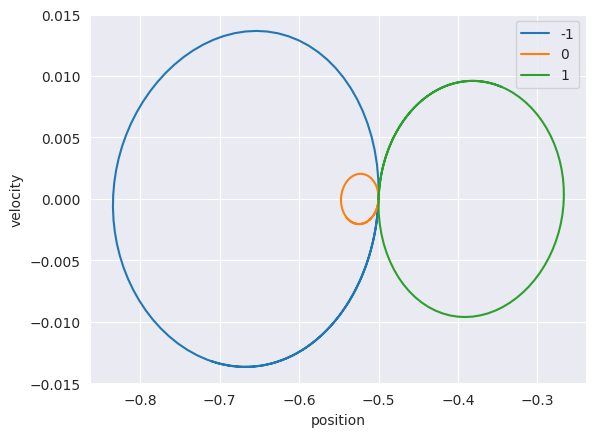

In [3]:
fig, ax = plt.subplots()
ax.set_xlabel("position")
ax.set_ylabel("velocity")
for action in [-1, 0, 1]:
    state = torch.tensor([-0.5,0])
    positions = [state[0].item()]
    velocities = [state[1].item()]
    for step in range(100):
        new_state, reward, is_terminal = update(state, action)
        positions.append(state[0].item())
        velocities.append(state[1].item())
        state = new_state
    ax.plot(positions, velocities, label=str(action))
    
plt.legend()

# Fourier Basis

The Fourier basis transforms a low-dimensional input to a high-dimensional space by applying cosine functions of varying frequencies to the inputs. Each feature in this high-dimensional space represents a separate basis function which can be scaled and combined with the other basis functions to approximate the value function. The Fourier basis is implemented below as a pytorch `Module` so that it can be easily swapped for a different basis or composed with other modules. Implementing it using pytorch also allows computations to be done on a GPU using Nvidia CUDA.

One very important point that was not discussed in the paper is that the Fourier basis assumes the input values to lie between zero and one. If this is not the case, the inputs must be scaled before passing them into the basis. For mountain car, the position varies between -1.2 and 0.5 and the velocity varies between -0.07 and 0.07. The `FourierBasis` class takes this into account by requiring a vector specifying the limits of the various inputs on initialization.

In [4]:
class FourierBasis(torch.nn.Module):
    def __init__(self, n, d, input_limits, device="cpu"):
        super(FourierBasis, self).__init__()
        self.n = n
        self.d = d
        self.device = device
        self.C = self.create_c_matrix()
        input_limits = torch.tensor(input_limits,device=device)
        self.lower_limits = input_limits[:,0]
        self.ranges = input_limits[:,1] - input_limits[:,0]

    def forward(self, vec):
        vec_scaled = (vec-self.lower_limits)/self.ranges
        features = torch.cos(torch.pi * torch.matmul(self.C, vec_scaled))
        return features

    def create_c_matrix(self):
        C_list = []
        count = np.zeros((self.d))
        final_count = np.ones((self.d))*(self.n+1)
        i = 0
        while i != self.d:
            C_list.append(list(count))
            i = 0
            done = False
            while not done and i < self.d:
                count[i] += 1
                if count[i] == (self.n+1):
                    count[i] = 0
                    done = False
                    i += 1
                else:
                    done = True
        return torch.tensor(C_list, dtype=torch.float32, device=self.device)

    def get_alpha_matrix(self, alpha_1):
        C_mag = torch.norm(self.C, dim=1)
        C_mag[0] = 1
        alpha = (alpha_1/C_mag).to(self.device)
        return alpha
    
    def __len__(self):
        return len(self.C)


The Fourier basis for two dimensions and an order of 3 can be visualized with the following code snippet.

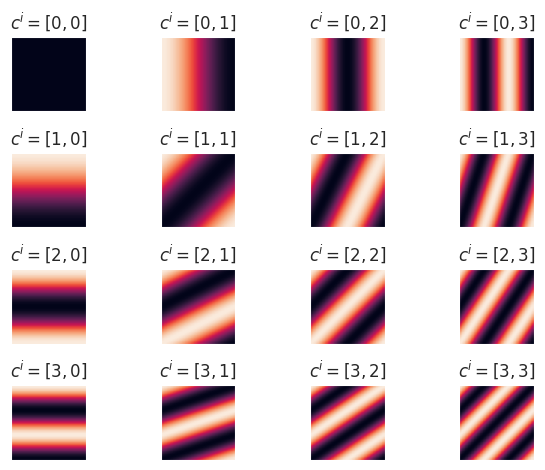

In [5]:
basis = FourierBasis(n=3, d=2, input_limits=[[0,3],[-1,1]])

x1s = np.linspace(0,3)
x2s = np.linspace(-1,1)
f = np.zeros((len(x1s),len(x2s),16))

for i, x1 in enumerate(x1s):
    for j, x2 in enumerate(x2s):
        f[j,i] = basis(torch.Tensor([x1,x2])).numpy()

assert len(basis) == 16


fig, axes = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axes[i,j].imshow(f[:,:,i*4+j])
        axes[i,j].set_title(f"$c^i=[{i},{j}]$")
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
plt.tight_layout()


# The Function Approximator

Now that the Fourier basis is defined, we can build a linear function approximator on top of it. The approximator consists of a vector of learnable weights that get dotted with the Fourier basis's output vector. The approximator must be a function of both the state and the action. We explored two different methods to take the action into account. Because the action has three discrete options, one approximator passed just the state through the Fourier basis and then used a separate set of weights for each different action. The other approximator used a 3-dimensional Fourier basis in which the position, velocity, and action were the three dimensions. The two approximators are defined below as pytorch modules.

In [6]:
class LinearBasisDiscreteAction(torch.nn.Module):
    def __init__(self, basis_order, input_limits, valid_actions, basis=FourierBasis, device="cpu"):
        super().__init__()
        self.device = device
        dimensions = 2
        self.basis = basis(basis_order, dimensions, input_limits[:dimensions], device)

        linear_layers = []
        self.action_map = {}
        for i, action in enumerate(valid_actions):
            self.action_map[action] = i
            layer = torch.nn.Linear(len(self.basis), 1, bias=False, device=device, dtype=None)
            layer.weight = torch.nn.Parameter(torch.zeros_like(layer.weight))
            linear_layers.append(layer)
        self.linear_layers = torch.nn.ModuleList(linear_layers)

    def forward(self, state, action):
        features = self.basis(state)
        action_index = self.action_map[action]
        v = self.linear_layers[action_index](features)

        return v

In [7]:
class LinearBasis(torch.nn.Module):
    def __init__(self, basis_order, input_limits, basis=FourierBasis, device="cuda", *args, **kwargs):
        super().__init__()
        self.device = device
        dimensions = 3
        self.basis = basis(basis_order, dimensions, input_limits[:dimensions], device)

        self.linear = torch.nn.Linear(len(self.basis), 1, bias=False, device=device, dtype=None)

    def forward(self, state, action):
        vec = torch.cat((state,torch.tensor([action])))
        features = self.basis(vec)
        v = self.linear(features)

        return v

# Training for one episode

Now that the approximators, basis, and physics update are defined, we can define a function that will implement the SARSA($\lambda$) algorithm for one episode.

In [9]:
def epsilon_greedy(state, actions, q_func, eps=0.01):
    qs = torch.tensor([q_func(state, action) for action in actions])

    r = torch.rand(1)
    if r >= eps:
        action_index = torch.argmax(qs)
    else:
        action_index = torch.randint(len(actions), (1,))

    return action_index


In [10]:
def train_episode(q_func, VALID_ACTIONS, eps, lam, gam, alpha_1, max_steps=50000):
    alpha = q_func.basis.get_alpha_matrix(alpha_1)

    x_start = np.random.uniform(-0.51,-0.49)
    xdot_start = np.random.uniform(-0.005,0.005)
    s = torch.tensor([x_start, xdot_start])
    a_i = epsilon_greedy(s, VALID_ACTIONS, q_func, eps=eps)
    a = VALID_ACTIONS[a_i]
    is_terminal = False
    zs = []
    for p in q_func.parameters():
        zs.append(torch.zeros_like(p.data))

    step = 0
    steps = [step]
    positions = [s[0].item()]
    velocities = [s[1].item()]
    actions = [a]
    while not is_terminal and step < max_steps:
        sp, reward, is_terminal = update(s, a)
        q_func.zero_grad()
        q = q_func(s, a)
        q.backward()

        ap_i = epsilon_greedy(sp, VALID_ACTIONS, q_func, eps=eps)
        ap = VALID_ACTIONS[ap_i]
        qp = q_func(sp, ap)
        delta = reward + gam*qp - q

        for z, w in zip(zs, q_func.parameters()):
            if w.grad is not None:
                z.mul_(gam*lam).add_(w.grad)
                w.data.add_(alpha*delta*z)
            else:
                z.mul_(gam*lam)
                w.data.add_(alpha*delta*z)

        s = sp
        a_i = ap_i
        a = ap
        steps.append(step)
        positions.append(s[0].item())
        velocities.append(s[1].item())
        actions.append(a)
        step += 1
    return step, (steps, positions, velocities, actions)


## Trajectories
The following code snippets show phase portraits with the trajectories followed by the car for episodes 1 and 10. Clearly the trajectory for phase 10 is shorter than that for phase 1, indicating that the agent has learned.

Text(0, 0.5, 'Velocity')

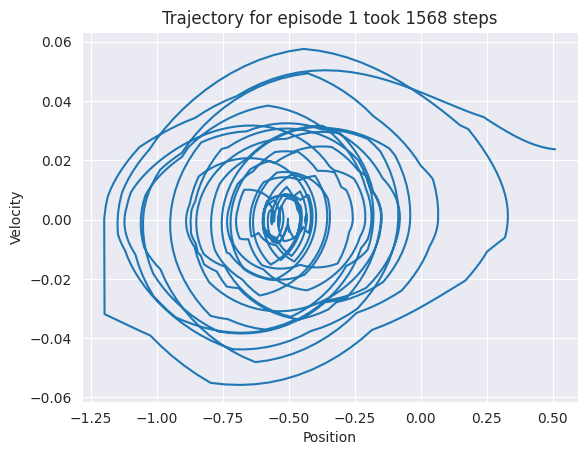

In [11]:
VALID_ACTIONS = [1, 0, -1]
input_limits=[[-1.2,0.6],[-0.07,0.07],[-1,1]]
q_func = LinearBasisDiscreteAction(valid_actions=VALID_ACTIONS, input_limits=input_limits, basis_order=3, device="cpu")

num_steps, trajectory = train_episode(q_func, VALID_ACTIONS, eps=0.0, lam=0.9, gam=1.0, alpha_1=0.001)
steps, positions, velocities, actions = trajectory

fig, ax = plt.subplots()
ax.plot(positions, velocities)
ax.set_title(f"Trajectory for episode 1 took {num_steps} steps")
ax.set_xlabel("Position")
ax.set_ylabel("Velocity")

Text(0, 0.5, 'Velocity')

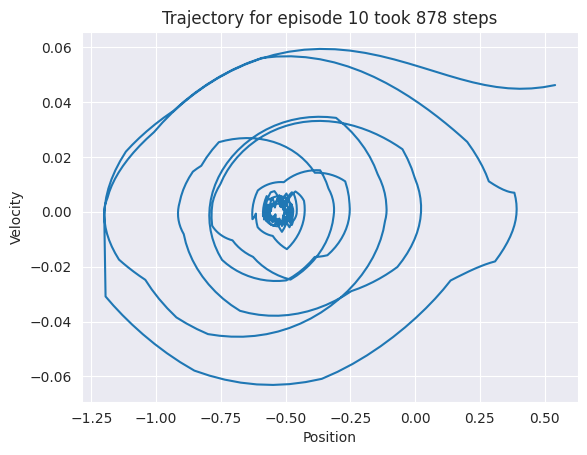

In [12]:
for i in range(9):
    num_steps, trajectory = train_episode(q_func, VALID_ACTIONS, eps=0.0, lam=0.9, gam=1.0, alpha_1=0.001)
steps, positions, velocities, actions = trajectory
fig, ax = plt.subplots()
ax.plot(positions, velocities)
ax.set_title(f"Trajectory for episode 10 took {num_steps} steps")
ax.set_xlabel("Position")
ax.set_ylabel("Velocity")

# Training for multiple episodes

We can now combine the code necessary to train for multiple episodes into a single function that will repeatedly train for as many episodes as desired. We can then plot the number of steps taken for each episode.

In [13]:
def train_epoch(q_func, VALID_ACTIONS, num_episodes, eps, gam, lam, alpha_1):
    alpha = q_func.basis.get_alpha_matrix(alpha_1)

    steps_per_episode = []

    for episode in range(num_episodes):
        num_steps, trajectory = train_episode(q_func, VALID_ACTIONS, eps, lam, gam, alpha_1)
        steps_per_episode.append(num_steps)

    return steps_per_episode


Text(0.5, 1.0, 'Steps to reach terminal state per episode')

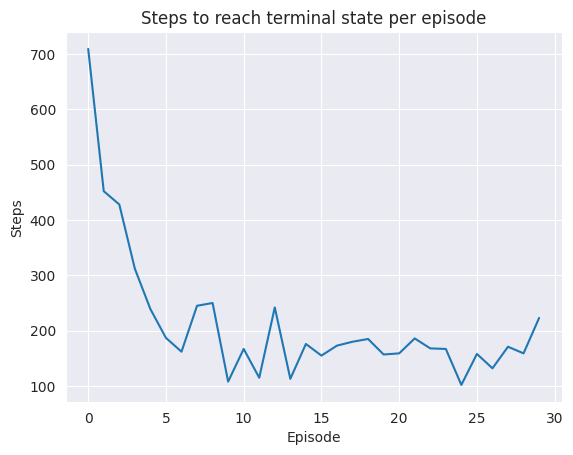

In [14]:
num_episodes = 30
VALID_ACTIONS = [1, 0, -1]
input_limits=[[-1.2,0.6],[-0.07,0.07],[-1,1]]
#q_func = LinearBasisDiscreteAction(basis_order=3, valid_actions=VALID_ACTIONS, input_limits=input_limits, device="cpu")
q_func = LinearBasis(basis_order=3, valid_actions=VALID_ACTIONS, input_limits=input_limits, device="cpu")

steps_per_episode = train_epoch(q_func, VALID_ACTIONS, num_episodes=30, eps=0.0, gam=1.0, lam=0.9, alpha_1=0.001)
fig, ax = plt.subplots()
ax.plot(steps_per_episode)
ax.set_xlabel("Episode")
ax.set_ylabel("Steps")
ax.set_title("Steps to reach terminal state per episode")

# Question 1

Q: Show learning curves for order 3, 5, and 7 Fourier bases, for a fixed setting of $\alpha$ and $\epsilon$, and $\gamma=1$, $\lambda=0.9$

A: First we will define a function that can train multiple times and aggregate the results. Then we can plot the results with Seaborn. We select $\alpha_1=0.001$ and $\epsilon=0.0$ to match the Konidaris paper.

In [15]:
def train_batch(model_class, order, num_trials, num_episodes):
    q_func = model_class(order, input_limits=input_limits, valid_actions=VALID_ACTIONS, device="cpu")
    steps_df = pd.DataFrame(columns=["ModelClass", "Order", "Trial", "Episode", "Steps"])

    for trial in range(num_trials):
        steps_per_episode = train_epoch(q_func, VALID_ACTIONS=VALID_ACTIONS, num_episodes=num_episodes, eps=0.0, gam=1.0, lam=0.9, alpha_1=0.001)
        steps_df = pd.concat([steps_df, pd.DataFrame({"ModelClass":model_class.__name__, "Order":str(order), "Trial":trial, "Episode":range(num_episodes), "Steps":steps_per_episode})])
        
    return steps_df, q_func

In [16]:
df = pd.DataFrame(columns=["ModelClass", "Order", "Trial", "Episode", "Steps"])
for model_class in [LinearBasisDiscreteAction, LinearBasis]:
    for order in [3, 5, 7]:
        batch_df, q_func = train_batch(model_class=model_class, order=order, num_trials=10, num_episodes=20)
        df = pd.concat([df, batch_df])

<Figure size 640x480 with 0 Axes>

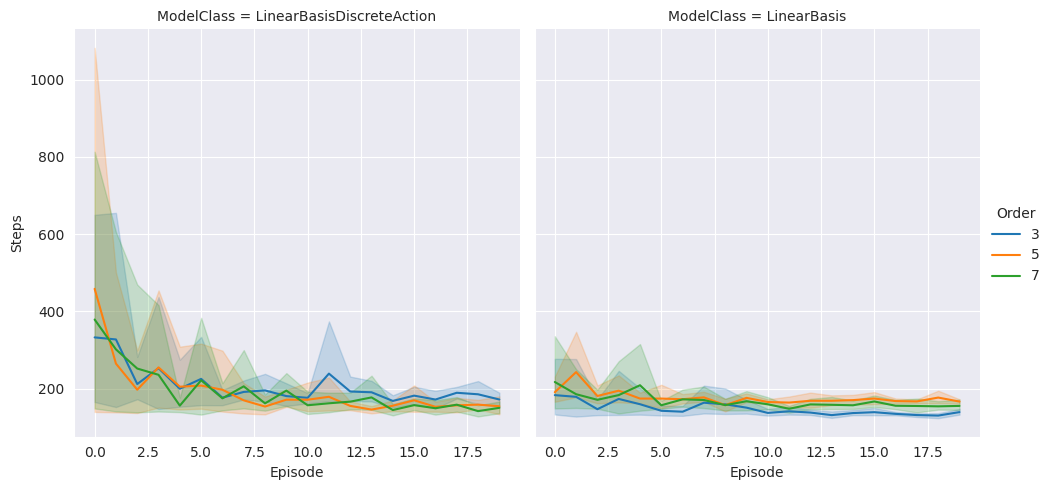

In [17]:
plt.figure()
sns.relplot(data=df, kind="line", err_style="band", x="Episode", y="Steps", hue="Order", col="ModelClass");

# Question 2

Q: Create a surface plot of the value function (the negative of the value function) of the learned
policies after 1,000 episodes, for the above orders. (Hint: Your plot should look like the one
in Sutton and Barto, but smoother.)

A: The following code trains both versions of the approximator with orders of 3, 5, and 7 for 1000 episodes. We can see that the approximator that treats the actions as discrete has a lower probability of un-learning at higher numbers of episodes. The resulting value functions are computed by taking the maximum value among the actions for every point in the state space. They all look similar to each other and to the value function from Sutton and Barto.

In [18]:
df = pd.DataFrame(columns=["ModelClass", "Order", "Trial", "Episode", "Steps"])
models = []
for model_class in [LinearBasisDiscreteAction, LinearBasis]:
    class_models = []
    for order in [3, 5, 7]:
        batch_df, q_func = train_batch(model_class=model_class, order=order, num_trials=1, num_episodes=1000)
        class_models.append(q_func)
        df = pd.concat([df, batch_df])
    models.append(class_models)

<Figure size 640x480 with 0 Axes>

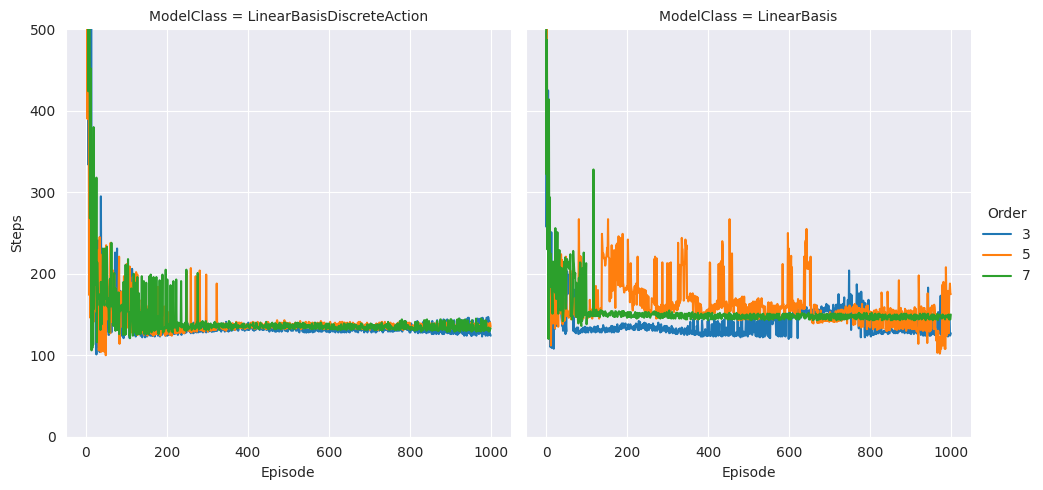

In [19]:
plt.figure()
g = sns.relplot(data=df, kind="line", col="ModelClass", hue="Order", x="Episode", y="Steps")
g.set(ylim=(0,500))

In [20]:
def plot_value_func(q_func, actions, ax):
    ps = np.linspace(-1.2, 0.6, 50)
    vs = np.linspace(-0.07, 0.07, 50)

    X, Y = np.meshgrid(ps, vs)
    Z = np.zeros_like(X)

    for i, p in enumerate(ps):
        for j, v in enumerate(vs):
            state = torch.tensor([p,v],dtype=torch.float32)
            qs = torch.tensor([q_func(state, action) for action in actions])
            Z[j,i] = torch.max(qs)

    ax.plot_surface(X,Y,-Z)
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    ax.set_zlabel("value")

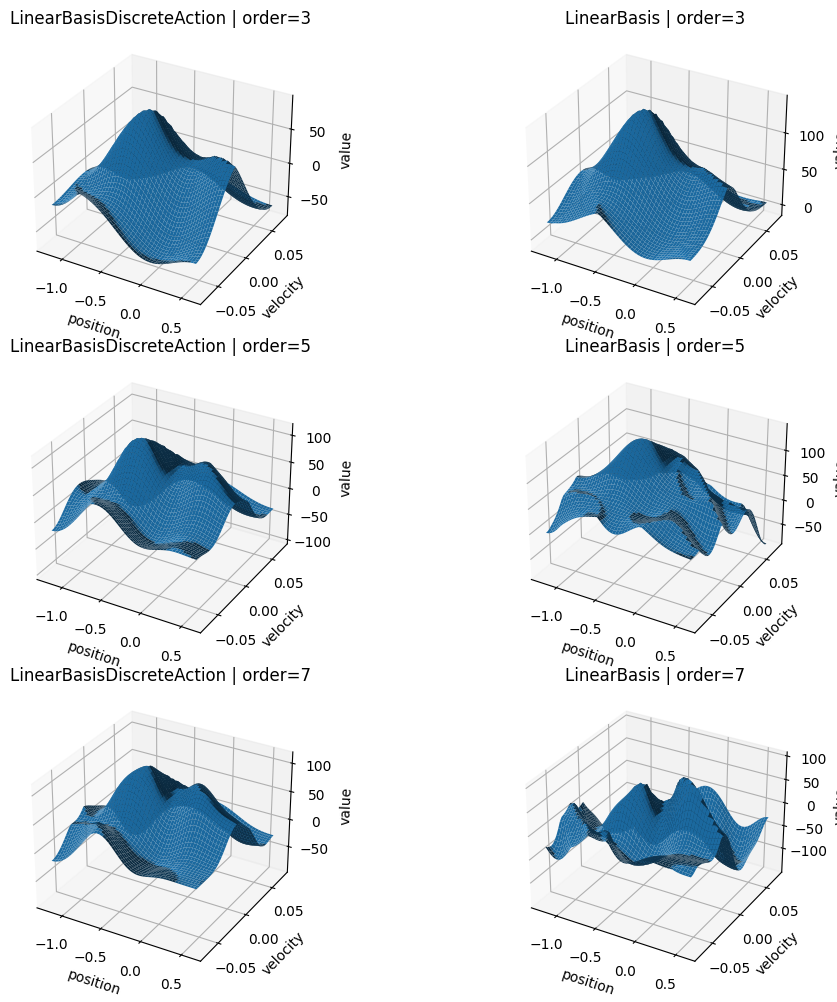

In [21]:
matplotlib.rc_file_defaults()
fig, axes = plt.subplots(3,2,subplot_kw={"projection":"3d"}, figsize=(12,10))

for i, model_class in enumerate([LinearBasisDiscreteAction, LinearBasis]):
    for j, order in enumerate([3, 5, 7]):
        plot_value_func(models[i][j], VALID_ACTIONS, axes[j,i])
        axes[j,i].set_title(f"{model_class.__name__} | order={order}")
plt.tight_layout()
sns.set_style("darkgrid")

# Question 3

## Part 1

Q: What would happen if $\gamma$ was less than 1 and the solution was many steps long?

A: We run two experiment below using $\gamma=0.9$ and $\gamma=0.4$. We show that the agent never reaches the terminal state if $\gamma$ is too low. This happens because the information to be gained is too local. The agent is unable to learn to avoid the starting region which is necessary for it to learn to find the terminal state. If $\gamma$ is too low, then states far in the future have almost no impact on the value of the current state.

In [22]:
VALID_ACTIONS = [1, 0, -1]
input_limits=[[-1.2,0.6],[-0.07,0.07],[-1,1]]
q_func = LinearBasisDiscreteAction(valid_actions=VALID_ACTIONS, input_limits=input_limits, basis_order=3, device="cpu")

num_steps1, trajectory = train_episode(q_func, VALID_ACTIONS, eps=0.0, lam=0.9, gam=0.9, alpha_1=0.001)
steps, positions1, velocities1, actions = trajectory
num_steps2, trajectory = train_episode(q_func, VALID_ACTIONS, eps=0.0, lam=0.9, gam=0.4, alpha_1=0.001)
steps, positions2, velocities2, actions = trajectory

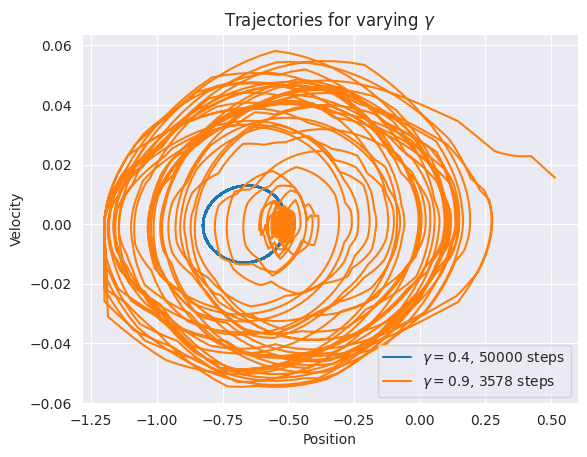

In [23]:
fig, ax = plt.subplots()
ax.plot(positions2, velocities2, label=f"$\gamma=0.4$, {num_steps2} steps")
ax.plot(positions1, velocities1, label=f"$\gamma=0.9$, {num_steps1} steps")
ax.set_title(f"Trajectories for varying $\gamma$")
ax.set_xlabel("Position")
ax.set_ylabel("Velocity")
plt.legend()

## Part 2
Q: What would happen if we had a zero step cost and a positive goal reward, for the case where $\gamma = 1$, and the case where $\gamma < 1$?

A: Below we redefine our update function to have a zero step cost and a positive goal reward. As illustrated in the trajectory that follows, the model is completely unable to learn because it always picks the best action, but none of the values in the value function change, so the best action never changes and the agent runs in circles forever.

In [24]:
def update(state, action):
    velocity = state[1] + action * \
        0.001 + np.cos(3*state[0])*(-0.0025)
    position = state[0] + velocity
    new_state = torch.tensor([position,velocity])
    if position >= 0.5:
        reward = 1
        is_terminal = True
    elif position < -1.2:
        reward = 0
        new_state[1] = 0.0
        new_state[0] = -1.2
        is_terminal = False
    else:
        reward = 0
        is_terminal = False

    return new_state, reward, is_terminal

In [25]:
VALID_ACTIONS = [1, 0, -1]
input_limits=[[-1.2,0.6],[-0.07,0.07],[-1,1]]
q_func = LinearBasisDiscreteAction(valid_actions=VALID_ACTIONS, input_limits=input_limits, basis_order=3, device="cpu")

num_steps, trajectory = train_episode(q_func, VALID_ACTIONS, eps=0.0, lam=0.9, gam=0.9, alpha_1=0.001)
steps, positions, velocities, actions = trajectory

Text(0, 0.5, 'Velocity')

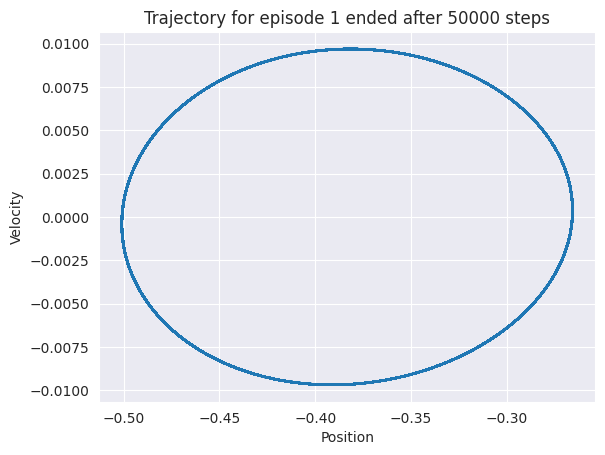

In [26]:
fig, ax = plt.subplots()
ax.plot(positions, velocities)
ax.set_title(f"Trajectory for episode 1 ended after {num_steps} steps")
ax.set_xlabel("Position")
ax.set_ylabel("Velocity")